In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import sample
from PIL import Image
import json
import csv
import re
from random import random
from random import seed

In [9]:
path = "/usr/users/vogg/FairMOT/src/data/"

with open(path + "macaquepose.train",'r') as f:
    lines = list(csv.reader(f))

In [10]:
lines[0][0]

'MacaquePose/images/01418849d54b3005.jpg'

In [11]:
for line in lines:
    x = re.sub("Pose", "CopyPaste", line[0])
    with open(path + "macaquecopypaste.train", 'a') as f:
        f.write(line[0]+"\n")
        f.write(x + "\n")

## Create labels

Before creating the labels the folder structure should be as in crowdhuman, i.e. one folder called images with subfolders train and val, containing single .jpg images.

And similarly one empty folder called labels_with_ids with subfolders train and val in which one .txt file for each .jpg file will be saved.

In [81]:
data_root = "/local_datasets/MacaquePose/"

my_dpi = 96
C = [(.8, .8, 0),(0, .8, .8),(.8, 0, .8),(0, 1, 0),(0, 0, 1), (1, 0, 0)]

with open(data_root + 'annotations.csv', 'r') as fp:
    data_annotation = list(csv.reader(fp, delimiter=','))

### Try one image

0142d1d1a6904a70.jpg


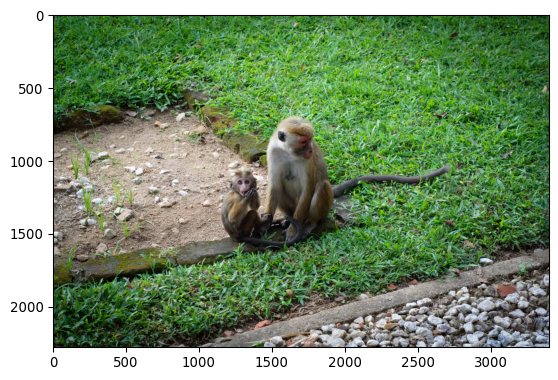

In [77]:

row = data_annotation[2]
print(row[0])

# load & draw image
img = np.asarray(Image.open(data_root + 'images/' + row[0]))
fig, ax = plt.subplots(figsize=(640/my_dpi, 640/my_dpi), dpi=my_dpi)
ax.imshow(img)

img_h, img_w, _ = img.shape

# load & draw segmentation
seg_string= row[2]
Seg = json.loads(seg_string)

[{'segment': [[1724.14, 886.38], [1641.86, 807.84], [1563.32, 736.78], [1443.64, 714.34], [1331.44, 800.36], [1316.48, 886.38], [1275.34, 961.18], [1338.92, 1125.74], [1387.54, 1282.82], [1481.04, 1320.22], [1578.28, 1342.66], [1697.96, 1301.52], [1735.36, 1211.76], [1765.28, 1028.5], [1761.54, 935]]}]
[{'segment': [[2214.08, 1596.98], [2273.92, 1529.66], [2292.62, 1447.38], [2247.74, 1361.36], [2161.72, 1309], [2086.92, 1267.86], [1993.42, 1260.38], [1866.26, 1245.42], [1742.84, 1297.78], [1645.6, 1409.98], [1585.76, 1525.92], [1611.94, 1596.98], [1600.72, 1645.6], [1671.78, 1705.44], [1727.88, 1705.44], [1802.68, 1739.1], [1870, 1739.1], [1922.36, 1776.5], [1944.8, 1720.4], [1982.2, 1701.7], [2045.78, 1716.66], [2101.88, 1742.84], [2172.94, 1754.06], [2232.78, 1750.32], [2270.18, 1675.52], [2315.06, 1630.64]]}]


In [78]:
# go monkey for monkey and transform segmentation coordinates into bounding boxes
for i_monkey, seg in enumerate(Seg):
    max_xa = []
    max_ya = []
    min_xa = []
    min_ya = []
    for s in seg:
        poly = np.array(s['segment'], np.float32)
        if len(poly) > 0:
            max_xa.append(max(sublist[0] for sublist in poly))
            min_xa.append(min(sublist[0] for sublist in poly))
            max_ya.append(max(sublist[1] for sublist in poly))
            min_ya.append(min(sublist[1] for sublist in poly))
    
    #Da ein Affe aus mehreren Polygonen zusammengesetzt sein kann, wollen wir nur die maximalen Maxima und minimalen Minima
    max_x = max(max_xa)
    min_x = min(min_xa)
    min_y = min(min_ya)
    max_y = max(max_ya)
    
    #Ins Format von FairMOT konvertieren
    x_center = (min_x + (max_x - min_x)/2) / img_w
    y_center = (min_y + (max_y - min_y)/2) / img_h
    w = (max_x - min_x) / img_w
    h = (max_y - min_y) / img_h
    
    
    #Label-String schreiben.

    label_str = '0 {:d} {:.6f} {:.6f} {:.6f} {:.6f}\n'.format(
            i_monkey, x_center , y_center , w , h )
    
    print(label_str)

0 0 0.421127 0.585059 0.169950 0.240743

0 1 0.614194 0.489881 0.378638 0.375105



In [17]:
len(data_annotation[1:])

13083

In [79]:
print(data_annotation[2])

['0142d1d1a6904a70.jpg', '[[{"name": "nose", "position": [1317, 1194]}, {"name": "left eye", "position": [1329.47, 1146.83]}, {"name": "right eye", "position": [1282.75, 1151.07]}, {"name": "left ear", "position": [1381, 1157]}, {"name": "right ear", "position": [1228, 1174]}, {"name": "left shoulder", "position": [1350, 1208]}, {"name": "right shoulder", "position": [1277, 1263]}, {"name": "left elbow", "position": [1386, 1326]}, {"name": "right elbow", "position": [1230, 1391]}, {"name": "left wrist", "position": [1389, 1254]}, {"name": "right wrist", "position": [1313, 1292]}, {"name": "left hip", "position": null}, {"name": "right hip", "position": [1297, 1526]}, {"name": "left knee", "position": null}, {"name": "right knee", "position": [1366, 1365]}, {"name": "left ankle", "position": null}, {"name": "right ankle", "position": [1409, 1442]}], [{"name": "nose", "position": [1774, 933]}, {"name": "left eye", "position": [1766.96, 853.75]}, {"name": "right eye", "position": [1718, 8

### All images

In [82]:
i_monkey = 0

for row in data_annotation[1:]:
    
    img_id = row[0]

    # load image
    img = np.asarray(Image.open(data_root + 'images/' + row[0]))

    img_h, img_w, _ = img.shape

    # load & draw segmentation
    seg_string= row[2]
    Seg = json.loads(seg_string)


    # go monkey for monkey and transform segmentation coordinates into bounding boxes
    for i, seg in enumerate(Seg):
        max_xa = []
        max_ya = []
        min_xa = []
        min_ya = []
        for s in seg:
            poly = np.array(s['segment'], np.float32)
            if len(poly) > 0:
                max_xa.append(max(sublist[0] for sublist in poly))
                min_xa.append(min(sublist[0] for sublist in poly))
                max_ya.append(max(sublist[1] for sublist in poly))
                min_ya.append(min(sublist[1] for sublist in poly))

        #Da ein Affe aus mehreren Polygonen zusammengesetzt sein kann, wollen wir nur die maximalen Maxima und minimalen Minima
        max_x = max(max_xa)
        min_x = min(min_xa)
        min_y = min(min_ya)
        max_y = max(max_ya)

        #Ins Format von FairMOT konvertieren
        x_center = (min_x + (max_x - min_x)/2) / img_w
        y_center = (min_y + (max_y - min_y)/2) / img_h
        w = (max_x - min_x) / img_w
        h = (max_y - min_y) / img_h


        img_id = re.sub("[.]jpg","", img_id)

        #Label-String schreiben.
        label_fpath = data_root + "labels_with_ids/" + img_id +'.txt'

        label_str = '0 {:d} {:.6f} {:.6f} {:.6f} {:.6f}\n'.format(
                i_monkey, x_center, y_center, w * 1.05, h * 1.05)

        with open(label_fpath, 'a') as f:
            f.write(label_str)

        i_monkey += 1
        if i_monkey % 1000 == 0:
            print(i_monkey)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


In [57]:
seed(64)

img_ids = [item[0] for item in data_annotation[1:]]


0.47615826222934565 0.6302190543188851 0.40396096956847294 0.9200240126763269 0.01685162040226995


In [58]:
for img_id in img_ids:
    if random() < 0.2:
        label_fpath = "/usr/users/vogg/FairMOT/src/data/macaquepose.val"

        label_str =  "MacaquePose/images/" + img_id + "\n"

        with open(label_fpath, 'a') as f:
            f.write(label_str)
    else:
        label_fpath = "/usr/users/vogg/FairMOT/src/data/macaquepose.train"

        label_str =  "MacaquePose/images/" + img_id + "\n"

        with open(label_fpath, 'a') as f:
            f.write(label_str)